## Predict roof and country, all data

Using rotated to hz + OpenCv border

Basic default transforms

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
from ipyexperiments import *

In [3]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [4]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [5]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [6]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [7]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [8]:
RESIZE_IMAGES = True

In [9]:
MODEL_NAME='cv_reflect_101'

In [10]:
NB_NUM='09_9'

In [11]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: ff23d753, DATE: 20191124


In [12]:
#DATE = '20191123'
#UID = 'b4030283'

In [13]:
SUB_NUM='2'

In [14]:
img_size=256
bs=128

In [15]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [16]:
test_names = get_image_files(test_images)

In [17]:
assert len(test_names)==7325

In [18]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [19]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


#### use only gold st_lucia cement

In [27]:
st_luc_cc_idxs=df_all.loc[(df_all['roof_material'] == 'concrete_cement') & (df_all['region'] == 'castries')].index



In [28]:
len(st_luc_cc_idxs)

89

In [29]:
len(df_all)

22553

In [30]:
df_all.drop(st_luc_cc_idxs,inplace=True)

In [31]:
len(df_all)

22464

In [33]:
df_sl_cc=pd.read_csv(data_dir/'st_lucia_castries_gold_concrete_cement.csv')

In [34]:
df_sl_cc['roof_material'] = 'concrete_cement'
df_sl_cc['country'] = 'st_lucia'
df_sl_cc['region'] = 'castries'
#pseudo verified
df_sl_cc['verified'] = True

In [36]:
df_all = df_all.append(df_sl_cc, ignore_index=True)

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [37]:
len(df_all)

22539

In [38]:
df_all.to_csv(data_dir/'df_all_repl_st_lucia_castries_gold_concrete_cement.csv', index=False)

In [39]:
#### Sepate roof types per country

In [40]:
df_all['target']=df_all['roof_material']+'_'+df_all['country']

In [41]:
df_all.head()

,country,id,region,roof_material,target,verified
0,colombia,7a3f2a10,borde_rural,concrete_cement,concrete_cement_colombia,True
1,colombia,7a1f731e,borde_rural,irregular_metal,irregular_metal_colombia,True
2,colombia,7a424ad8,borde_rural,healthy_metal,healthy_metal_colombia,True
3,colombia,7a3edc5e,borde_rural,healthy_metal,healthy_metal_colombia,True
4,colombia,7a303a6e,borde_rural,healthy_metal,healthy_metal_colombia,True


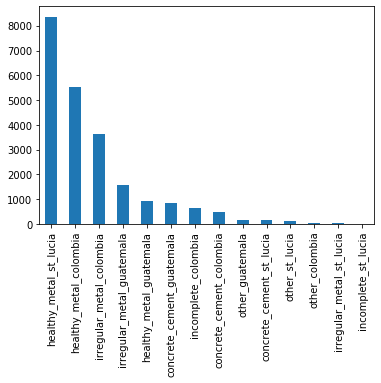

In [42]:
df_all.target.value_counts().plot(kind='bar')

In [43]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [44]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [45]:
assert len(df_test)==7325

In [46]:
df_all.loc[df_all['id'] == '7a204ec4']

,country,id,region,roof_material,target,verified
12960,guatemala,7a204ec4,mixco_1_and_ebenezer,irregular_metal,irregular_metal_guatemala,True


In [47]:
len(df_all)

22539

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [48]:
#xtra_tfms=[rand_crop(p=0.4)], 
#tfms = get_transforms(flip_vert=True, max_lighting=0.25, max_zoom=1.2, max_warp=0., xtra_tfms=xtra_tfms)

tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [49]:
np.random.seed(42)
dep_var='target'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.1)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

22539


In [50]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [51]:
#to check what params object has
#dir(data)

In [52]:
data.label_list

LabelLists;

Train: LabelList (20286 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement_colombia,irregular_metal_colombia,healthy_metal_colombia,healthy_metal_colombia,healthy_metal_colombia
Path: data/train/rotated/clipped/256;

Valid: LabelList (2253 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal_st_lucia,irregular_metal_colombia,healthy_metal_st_lucia,healthy_metal_st_lucia,healthy_metal_st_lucia
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [53]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

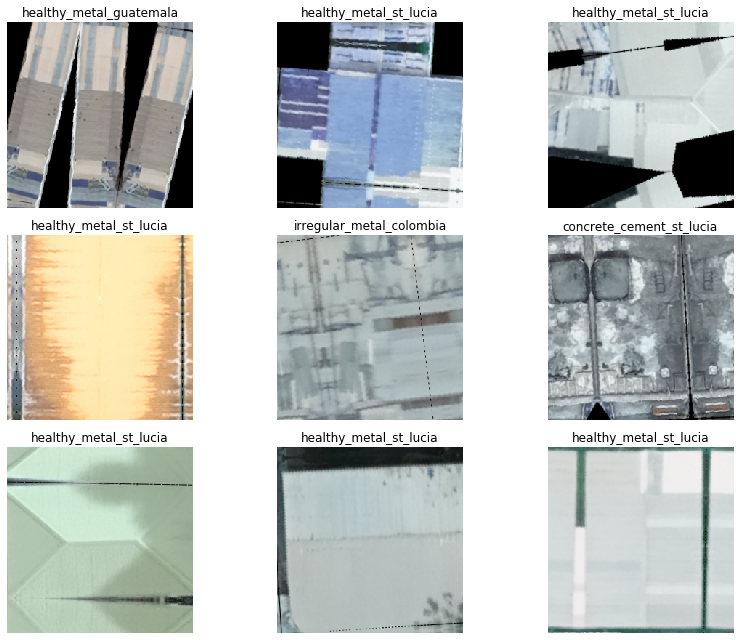

In [54]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [55]:
#exp1 = IPyExperimentsPytorch()

In [56]:
arch = models.resnet50
arch_name = 'rn50'

In [57]:
#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2)

In [58]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

In [59]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [60]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


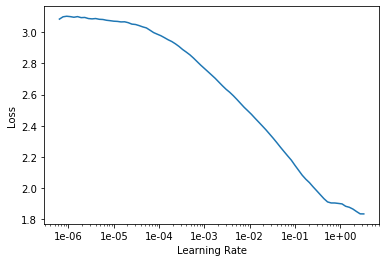

In [61]:
learn.recorder.plot()

Then we can fit the head of our network.

In [62]:
lr = 1e-2

In [63]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.229437,0.700610,0.186418,00:53
1,0.628722,0.462983,0.156680,00:53
2,0.484567,0.416923,0.150022,00:53
3,0.424505,0.391963,0.132712,00:57
4,0.400470,0.390607,0.129605,00:53


In [64]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [65]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')


In [66]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.413825,0.391380,0.135375,00:56
1,0.423551,0.388016,0.136707,00:53
2,0.398483,0.380588,0.134931,00:53
3,0.372563,0.366034,0.126942,00:53
4,0.348155,0.364620,0.126054,00:55


In [67]:
learn.save(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [68]:
learn.load(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (20286 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement_colombia,irregular_metal_colombia,healthy_metal_colombia,healthy_metal_colombia,healthy_metal_colombia
Path: data/train/rotated/clipped/256;

Valid: LabelList (2253 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal_st_lucia,irregular_metal_colombia,healthy_metal_st_lucia,healthy_metal_st_lucia,healthy_metal_st_lucia
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)


In [69]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal_colombia', 'healthy_metal_colombia', 71),
 ('healthy_metal_colombia', 'irregular_metal_colombia', 63),
 ('incomplete_colombia', 'irregular_metal_colombia', 28),
 ('other_st_lucia', 'healthy_metal_st_lucia', 12),
 ('concrete_cement_st_lucia', 'healthy_metal_st_lucia', 8),
 ('healthy_metal_colombia', 'healthy_metal_st_lucia', 8),
 ('healthy_metal_st_lucia', 'healthy_metal_colombia', 8),
 ('irregular_metal_colombia', 'healthy_metal_st_lucia', 7),
 ('irregular_metal_colombia', 'incomplete_colombia', 6),
 ('healthy_metal_colombia', 'concrete_cement_colombia', 5),
 ('healthy_metal_guatemala', 'irregular_metal_guatemala', 5),
 ('incomplete_colombia', 'concrete_cement_colombia', 5),
 ('irregular_metal_guatemala', 'healthy_metal_guatemala', 5),
 ('other_guatemala', 'irregular_metal_guatemala', 5),
 ('concrete_cement_colombia', 'incomplete_colombia', 4),
 ('concrete_cement_guatemala', 'healthy_metal_guatemala', 4),
 ('healthy_metal_guatemala', 'concrete_cement_guatemala', 4),


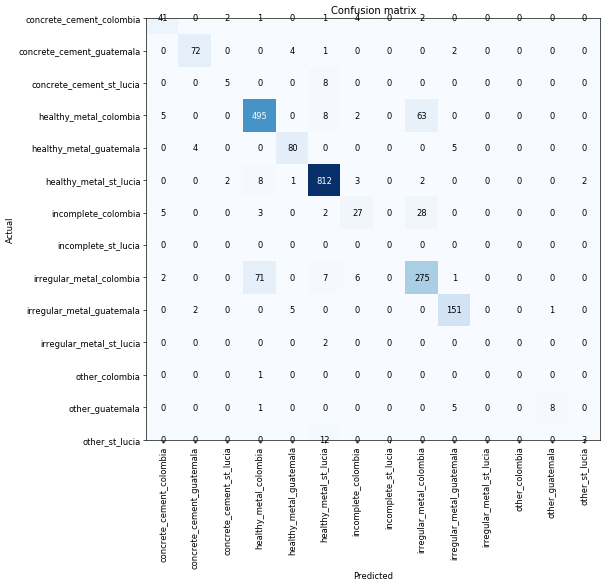

In [70]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [71]:
#exp2 = IPyExperimentsPytorch()

In [72]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


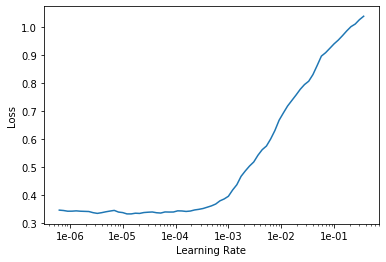

In [73]:
learn.lr_find()
learn.recorder.plot()

In [74]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.367126,0.401758,0.147359,01:09
1,0.400768,0.400747,0.138038,01:10
2,0.359016,0.363901,0.126942,01:09
3,0.308858,0.354483,0.122059,01:10
4,0.262132,0.352462,0.119396,01:09


In [75]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [76]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (20286 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement_colombia,irregular_metal_colombia,healthy_metal_colombia,healthy_metal_colombia,healthy_metal_colombia
Path: data/train/rotated/clipped/256;

Valid: LabelList (2253 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal_st_lucia,irregular_metal_colombia,healthy_metal_st_lucia,healthy_metal_st_lucia,healthy_metal_st_lucia
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)


In [77]:
#learn.fit_one_cycle(5, slice(1e-6, lr/5))

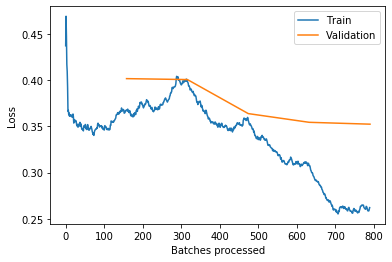

In [78]:
learn.recorder.plot_losses()

In [79]:
#learn.save(f'stage-2-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [80]:
learn = learn.to_fp32()

In [81]:
learn.export(f'stage-2-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [82]:
learn.export()

### inference

In [83]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [84]:
len(test_dataset)

15325

In [85]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [86]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [87]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [88]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [89]:
len(learn.dl(DatasetType.Test))

240

In [90]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [91]:
learn.data.c

14

In [92]:
learn.data.classes

['concrete_cement_colombia',
 'concrete_cement_guatemala',
 'concrete_cement_st_lucia',
 'healthy_metal_colombia',
 'healthy_metal_guatemala',
 'healthy_metal_st_lucia',
 'incomplete_colombia',
 'incomplete_st_lucia',
 'irregular_metal_colombia',
 'irregular_metal_guatemala',
 'irregular_metal_st_lucia',
 'other_colombia',
 'other_guatemala',
 'other_st_lucia']

In [93]:
preds.shape

torch.Size([15325, 14])

In [94]:
labels = np.argmax(preds, 1)

In [95]:
len(preds)

15325

In [96]:
preds[0].tolist()

[0.00014925669529475272,
 0.1394054889678955,
 0.00022604352852795273,
 0.0018755205674096942,
 0.8455302715301514,
 0.0017535639926791191,
 0.00016396127466578037,
 0.0002047636517090723,
 0.0002692773996386677,
 0.008948426693677902,
 0.00011504123540362343,
 0.0004156922805123031,
 0.0005698336171917617,
 0.00037294108187779784]

In [97]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [98]:
learn.data.classes

['concrete_cement_colombia',
 'concrete_cement_guatemala',
 'concrete_cement_st_lucia',
 'healthy_metal_colombia',
 'healthy_metal_guatemala',
 'healthy_metal_st_lucia',
 'incomplete_colombia',
 'incomplete_st_lucia',
 'irregular_metal_colombia',
 'irregular_metal_guatemala',
 'irregular_metal_st_lucia',
 'other_colombia',
 'other_guatemala',
 'other_st_lucia']

In [99]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [100]:
test_predictions[0]

'healthy_metal_guatemala'

In [101]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [102]:
preds_list[0]

[0.00014925669529475272,
 0.1394054889678955,
 0.00022604352852795273,
 0.0018755205674096942,
 0.8455302715301514,
 0.0017535639926791191,
 0.00016396127466578037,
 0.0002047636517090723,
 0.0002692773996386677,
 0.008948426693677902,
 0.00011504123540362343,
 0.0004156922805123031,
 0.0005698336171917617,
 0.00037294108187779784]

In [103]:
cols = list(learn.data.classes.copy())
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [104]:
cols

['id',
 'concrete_cement_colombia',
 'concrete_cement_guatemala',
 'concrete_cement_st_lucia',
 'healthy_metal_colombia',
 'healthy_metal_guatemala',
 'healthy_metal_st_lucia',
 'incomplete_colombia',
 'incomplete_st_lucia',
 'irregular_metal_colombia',
 'irregular_metal_guatemala',
 'irregular_metal_st_lucia',
 'other_colombia',
 'other_guatemala',
 'other_st_lucia']

In [105]:
df.head()

,id,pred
0,7a4d9168,"[0.00014925669529475272, 0.1394054889678955, 0..."
1,7a4ae922,"[0.0029921275563538074, 0.0004984377883374691,..."
2,7a48ca98,"[0.0033351066522300243, 0.0003660263027995825,..."
3,7a49c614,"[0.001054639695212245, 0.000218769462662749, 0..."
4,7a4dd4f2,"[0.00047415346489287913, 0.0001066937402356416..."


In [106]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [107]:
pred_df.insert(loc=0, column='id', value=ids)

In [108]:
pred_df.columns = cols

In [109]:
pred_df.head()

,id,concrete_cement_colombia,concrete_cement_guatemala,concrete_cement_st_lucia,healthy_metal_colombia,healthy_metal_guatemala,healthy_metal_st_lucia,incomplete_colombia,incomplete_st_lucia,irregular_metal_colombia,irregular_metal_guatemala,irregular_metal_st_lucia,other_colombia,other_guatemala,other_st_lucia
0,7a4d9168,0.000149,0.139405,0.000226,0.001876,0.845530,0.001754,0.000164,0.000205,0.000269,0.008948,0.000115,0.000416,0.000570,0.000373
1,7a4ae922,0.002992,0.000498,0.000408,0.969104,0.000316,0.000631,0.000547,0.000170,0.023647,0.000602,0.000232,0.000200,0.000349,0.000302
2,7a48ca98,0.003335,0.000366,0.000308,0.224397,0.000533,0.001438,0.015833,0.000272,0.749352,0.000966,0.000558,0.001125,0.000526,0.000990
3,7a49c614,0.001055,0.000219,0.000325,0.609065,0.000278,0.000218,0.001233,0.000211,0.385255,0.000648,0.000264,0.000331,0.000354,0.000545
4,7a4dd4f2,0.000474,0.000107,0.000099,0.980152,0.000299,0.000397,0.000154,0.000194,0.012721,0.000787,0.000272,0.000994,0.003202,0.000147


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


#### combine to just roof material

In [110]:
pred_df["concrete_cement"] = pred_df[["concrete_cement_colombia", "concrete_cement_guatemala","concrete_cement_st_lucia"]].max(axis=1)

In [111]:
pred_df["healthy_metal"] = pred_df[["healthy_metal_colombia", "healthy_metal_guatemala","healthy_metal_st_lucia"]].max(axis=1)

TODO check why

In [112]:
#pred_df["incomplete"] = pred_df[["incomplete_colombia", "incomplete_guatemala","incomplete_st_lucia"]].max(axis=1)

In [113]:
pred_df["incomplete"] = pred_df[["incomplete_colombia", "incomplete_st_lucia"]].max(axis=1)

In [114]:
pred_df["irregular_metal"] = pred_df[["irregular_metal_colombia", "irregular_metal_guatemala","irregular_metal_st_lucia"]].max(axis=1)

In [115]:
pred_df["other"] = pred_df[["other_colombia", "other_guatemala","other_st_lucia"]].max(axis=1)

#### drop country

In [116]:
pred_df.drop(columns=["concrete_cement_colombia", "concrete_cement_guatemala","concrete_cement_st_lucia", "healthy_metal_colombia", "healthy_metal_guatemala","healthy_metal_st_lucia", "incomplete_colombia", "incomplete_st_lucia", "irregular_metal_colombia", "irregular_metal_guatemala","irregular_metal_st_lucia", "other_colombia", "other_guatemala","other_st_lucia"],inplace=True)

In [117]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.139405,0.845530,0.000205,0.008948,0.000570
1,7a4ae922,0.002992,0.969104,0.000547,0.023647,0.000349
2,7a48ca98,0.003335,0.224397,0.015833,0.749352,0.001125
3,7a49c614,0.001055,0.609065,0.001233,0.385255,0.000545
4,7a4dd4f2,0.000474,0.980152,0.000194,0.012721,0.003202


#### Format correctly

In [118]:
pred_ids=pred_df['id'].values.tolist()

In [119]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [120]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [121]:
baseline_ids=df_baseline['id'].values.tolist()

In [122]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [123]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [124]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.139405,0.845530,0.000205,0.008948,0.000570,7a4d9168
1,7a4ae922,0.002992,0.969104,0.000547,0.023647,0.000349,7a4ae922
2,7a48ca98,0.003335,0.224397,0.015833,0.749352,0.001125,7a48ca98
3,7a49c614,0.001055,0.609065,0.001233,0.385255,0.000545,7a49c614
4,7a4dd4f2,0.000474,0.980152,0.000194,0.012721,0.003202,7a4dd4f2


In [125]:
pred_df=pred_df.sort_values('id_cat')

In [126]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
8041,7a4d630a,0.001001,0.971363,0.000746,0.016517,0.000897,7a4d630a
716,7a4d630a,0.001001,0.971363,0.000746,0.016517,0.000897,7a4d630a
764,7a4bbbd6,0.000765,0.962487,0.000558,0.032541,0.000302,7a4bbbd6
8089,7a4bbbd6,0.000765,0.962487,0.000558,0.032541,0.000302,7a4bbbd6
1841,7a4ac744,0.006342,0.356771,0.010010,0.496867,0.004346,7a4ac744


In [127]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [128]:
arch_name='rn50'

In [129]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [130]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
8041,7a4d630a,0.001001,0.971363,0.000746,0.016517,0.000897
764,7a4bbbd6,0.000765,0.962487,0.000558,0.032541,0.000302
1841,7a4ac744,0.006342,0.356771,0.010010,0.496867,0.004346
3363,7a4881fa,0.000421,0.053732,0.002815,0.938311,0.000415
7458,7a4aa4a8,0.007884,0.602204,0.013940,0.133501,0.010671


In [131]:
print(f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

submissions/stage-2-rn50-09_9-cv_reflect_101-20191124-ff23d753.csv


In [132]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [133]:
### Submission 2: 0.4461


In [134]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

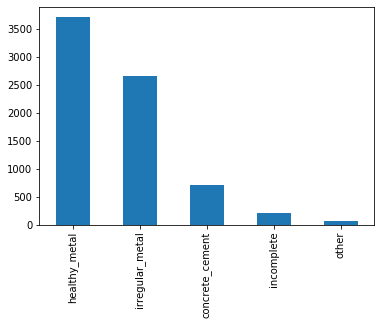

In [135]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")